# IMDB

#### Extract tar file

Check whether the aclImdb directory exists. If it does not, open aclImdb_v1.tar.gz and extract its contents into the current directory.

In [1]:
import os, tarfile

tar_path = "aclImdb_v1.tar.gz"
data_path = "aclImdb"

if not os.path.exists(data_path):
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=".", filter="data")
    print(f"{tar_path} extraction complete.")
else:
    print(f"{data_path} already exists. Skipping {tar_path} extraction.")

aclImdb already exists. Skipping aclImdb_v1.tar.gz extraction.


#### Try to setup local Apple device

Select a compute device (I am using a Macbook Pro M4). Prefer Apple MPS if available and set device to "mps". Otherwise fall back to "cpu".

In [2]:
import torch

device = (
    "mps"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

Using device: mps


#### Split training data

Set the dataset root from data_path. Build paths to the train and test positive and negative folders. Define a loader that reads every .txt review. Cleans <br /> tags, strip whitespace, and assign labels. Read and combine the positive and negative training reviews with labels 1 and 0 and then create a DataFrame. Create a stratified 90 to 10 train and validation split with a fixed random seed. Read and combine the positive and negative test reviews into a separate DataFrame.

In [3]:
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split

root = Path(data_path)
train_pos = root / "train" / "pos"
train_neg = root / "train" / "neg"
test_pos = root / "test" / "pos"
test_neg = root / "test" / "neg"


def load_dir(d: Path, label: int):
    rows = []
    for fp in d.glob("*.txt"):
        txt = fp.read_text(encoding="utf-8")
        rows.append({"text": txt.replace("<br />", "\n").strip(), "label": label})
    return rows


train_rows = load_dir(train_pos, 1) + load_dir(train_neg, 0)
df = pd.DataFrame(train_rows)

train_df, val_df = train_test_split(
    df, test_size=0.1, random_state=17, stratify=df["label"]
)

test_rows = load_dir(test_pos, 1) + load_dir(test_neg, 0)
test_df = pd.DataFrame(test_rows)

print(f"len(train_df): {len(train_df)}")
print(f"len(val_df): {len(val_df)}")
print(f"len(test_df): {len(test_df)}")


len(train_df): 22500
len(val_df): 2500
len(test_df): 25000


#### Perform tokenization

Convert the train, validation, and test DataFrames into Hugging Face Dataset objects and then combine them into a DatasetDict. Load the DistilBERT tokenizer. Define a batch tokenization function that truncates and pads to length 256. Map it across all splits while removing the text column. Rename label to labels to match the model’s expected input.

In [4]:
from datasets import Dataset, DatasetDict
from transformers import DistilBertTokenizerFast

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

print(train_ds)
print(val_ds)
print(test_ds)

raw = DatasetDict(
    {
        "train": train_ds,
        "validation": val_ds,
        "test": test_ds,
    }
)

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


def tok(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )


tokenized = raw.map(tok, batched=True, remove_columns=["text"])
tokenized = tokenized.rename_column("label", "labels")

print(tokenized)
print(tokenized["train"][0].keys())
print(len(tokenized["train"][0]["input_ids"]))

Dataset({
    features: ['text', 'label'],
    num_rows: 22500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})
dict_keys(['labels', 'input_ids', 'attention_mask'])
256


#### Create the model

Load DistilBERT sequence classification model configured for two labels. Define a helper function that counts total parameters and the subset that are trainable. Compute counts for the model.

In [5]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)


def count_params(m):
    return sum(p.numel() for p in m.parameters()), sum(
        p.numel() for p in m.parameters() if p.requires_grad
    )


total, trainable = count_params(model)

print(f"Params total: {total}  trainable: {trainable}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params total: 66955010  trainable: 66955010


#### Train for several epochs

Load a new DistilBERT sequence classifier with two labels. Define a metric function that converts logits to predictions and computes accuracy and F1. Create training arguments that set output directory, batch sizes, learning rate, epoch count, weight decay, logging frequency, and seed. Build a Trainer with the model, arguments, tokenized training data, validation data, and metrics function. Start training for three epochs.

In [6]:
import numpy as np

from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }


args = TrainingArguments(
    output_dir="imdb-distilbert",
    dataloader_pin_memory=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    seed=17,
    logging_strategy="no",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=8439, training_loss=0.20985117692039934, metrics={'train_runtime': 783.5032, 'train_samples_per_second': 86.152, 'train_steps_per_second': 10.771, 'total_flos': 4470774704640000.0, 'train_loss': 0.20985117692039934, 'epoch': 3.0})

#### Evaluate training results

Evaluate the trained model on the tokenized test set. Capture the resulting metrics dictionary and inspect.

In [7]:
import json
import numpy as np

test_metrics = trainer.evaluate(tokenized["test"])

print(json.dumps(test_metrics, indent=2))

{
  "eval_loss": 0.3970693349838257,
  "eval_accuracy": 0.91668,
  "eval_precision": 0.9167116860898716,
  "eval_recall": 0.9166799999999999,
  "eval_f1": 0.9166784160900185,
  "eval_runtime": 88.6076,
  "eval_samples_per_second": 282.143,
  "eval_steps_per_second": 17.64,
  "epoch": 3.0
}


#### Save the model

Save the trained model and config. Load the DistilBERT tokenizer checkpoint and write out its tokenizer files. Ensure both model and tokenizer can be reloaded together for inference.

In [8]:
from transformers import AutoTokenizer

save_dir = "imdb-distilbert/best"

trainer.save_model(save_dir)
AutoTokenizer.from_pretrained("distilbert-base-uncased").save_pretrained(save_dir)

('imdb-distilbert/best/tokenizer_config.json',
 'imdb-distilbert/best/special_tokens_map.json',
 'imdb-distilbert/best/vocab.txt',
 'imdb-distilbert/best/added_tokens.json',
 'imdb-distilbert/best/tokenizer.json')

#### Fix labels

Load the saved classifier. Assign readable label mappings for both id2label and label2id. Save the updated model so future loads return the human readable labels.

In [9]:
save_dir = "imdb-distilbert/best"

model = AutoModelForSequenceClassification.from_pretrained(save_dir).to(device)
model.config.id2label = {0: "NEGATIVE", 1: "POSITIVE"}
model.config.label2id = {"NEGATIVE": 0, "POSITIVE": 1}
model.save_pretrained(save_dir)

#### Test sample reviews

Create a sentiment analysis pipeline using the saved model. Run the pipeline on two texts to produce predicted sentiment labels and confidence scores.

In [10]:
from transformers import pipeline

clf = pipeline("sentiment-analysis", model="imdb-distilbert/best")

texts = [
    "I thought the movie was outstanding. The acting pulled me in.",
    "I thought the movie was terrible. The acting was dull and uninspired.",
]

clf(texts)

Device set to use mps:0


[{'label': 'POSITIVE', 'score': 0.9988242983818054},
 {'label': 'NEGATIVE', 'score': 0.9988081455230713}]

#### Inspect performance

Generate predictions on the tokenized test set. Extract true labels and derive predicted class indices with argmax over the logits. Compute a confusion matrix from the labels. Build a ConfusionMatrixDisplay and render the confusion matrix.

              precision    recall  f1-score   support

    NEGATIVE       0.91      0.92      0.92     12500
    POSITIVE       0.92      0.91      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



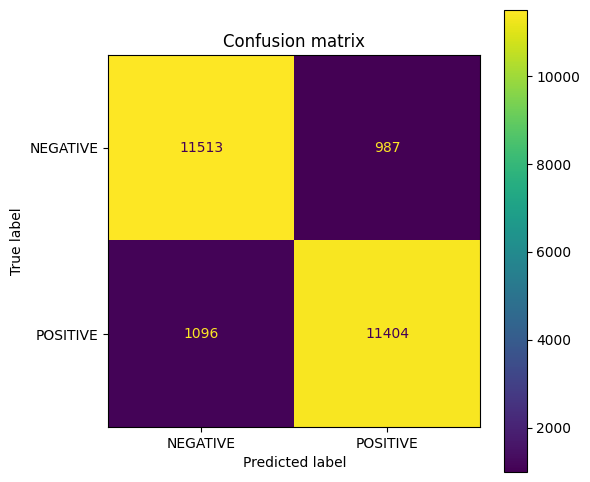

In [11]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pred = trainer.predict(tokenized["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=["NEGATIVE", "POSITIVE"]))
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion matrix")
plt.show()

#### Find mistakes

Generate predictions on the test set and convert logits to probabilities with softmax. Extract true labels and predicted classes. Identify misclassified indices and sort them by model confidence in descending order. Select the top three false positives and the top three false negatives. Define a helper that prints each selected sample’s index, true and predicted labels, the positive and negative probabilities, and a truncated snippet of the review text. Call the helper to display the false positives and then the false negatives.

In [12]:
import torch

from torch.nn.functional import softmax
from textwrap import shorten

pred = trainer.predict(tokenized["test"])
logits = torch.tensor(pred.predictions)
probs = softmax(logits, dim=-1).numpy()
y_true = pred.label_ids
y_pred = probs.argmax(axis=1)

wrong = np.where(y_pred != y_true)[0]
conf_wrong = wrong[np.argsort(probs[wrong].max(axis=1))[::-1]]

fp = [i for i in conf_wrong if y_pred[i] == 1][:3]
fn = [i for i in conf_wrong if y_pred[i] == 0][:3]


def show(ixs, title):
    print(title)
    for i in ixs:
        print(
            f"idx={i} true={y_true[i]} pred={y_pred[i]} p_pos={probs[i,1]:.3f} p_neg={probs[i,0]:.3f}"
        )
        print(
            shorten(
                test_df.iloc[i]["text"].replace("\n", " "), width=220, placeholder="..."
            )
        )
        print()


show(fp, "False positives")
show(fn, "False negatives")

False positives
idx=23766 true=0 pred=1 p_pos=0.999 p_neg=0.001
There are those who gripe that this is NOT the opera, but then they don't quibble with the film of CABARET that was not the original show either. All films of musicals/operas are and have to be "adaptations" or they...

idx=19838 true=0 pred=1 p_pos=0.999 p_neg=0.001
This is definitely one of the best Kung fu movies in the history of Cinema. The screenplay is really well done (which is not often the case for this type of movies) and you can see that Chuck (in one of his first...

idx=23777 true=0 pred=1 p_pos=0.999 p_neg=0.001
This has to be one of the all time greatest horror movies. Charles Band made the best movie of 96' in this little seen gem. Highly realistic and , incredibly stylised- with a visual flair David Fincher would envy, its...

False negatives
idx=5241 true=1 pred=0 p_pos=0.001 p_neg=0.999
Stupidly beautiful. This movie epitomizes the 'so bad it's good' genre of films. The only two talents in it are Richar

#### Verify index alignment

Run prediction on the test split. Extract true labels and compute predicted classes, then find the indices where predictions differ from truth. For the first five misclassifications, compare the label stored in the tokenized dataset to the label in the original DataFrame to verify alignment.

In [13]:
pred = trainer.predict(tokenized["test"])
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)
wrong = np.where(y_pred != y_true)[0]

for i in wrong[:5]:
    print(
        "idx:",
        i,
        "| dataset_label:",
        int(tokenized["test"][i]["labels"]),
        "| df_label:",
        int(test_df.iloc[i]["label"]),
    )

idx: 17 | dataset_label: 1 | df_label: 1
idx: 55 | dataset_label: 1 | df_label: 1
idx: 58 | dataset_label: 1 | df_label: 1
idx: 62 | dataset_label: 1 | df_label: 1
idx: 70 | dataset_label: 1 | df_label: 1


#### Check truncation

Load the DistilBERT tokenizer. Randomly sample 2K training reviews. Tokenize each sample without truncation and measure token sequence lengths. Compute the fraction of samples longer than 256 tokens and the maximum observed length.

In [14]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
tokenizer.model_max_length = 10_000

sample = train_df["text"].sample(2000, random_state=17).tolist()
lens = [len(tokenizer(t, truncation=False)["input_ids"]) for t in sample]

frac_trunc = float(np.mean(np.array(lens) > 256))
max_len = int(np.max(lens))

print("Fraction > 256:", round(frac_trunc, 3), "Max length:", max_len)

Fraction > 256: 0.41 Max length: 1799


#### Re-tokenize at longer maximum length

Create a new DatasetDict from the train, validation, and test splits. Load the DistilBERT tokenizer. Define a tokenization function that truncates and pads each review to a longer length of 320. Map this function across all splits in batch. Drop the text column, and rename label to labels to match the model input. Verify that token sequences are length 320.

In [15]:
raw = DatasetDict(
    {
        "train": train_ds,
        "validation": val_ds,
        "test": test_ds,
    }
)

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


def tok320(batch):
    return tokenizer(
        batch["text"], truncation=True, padding="max_length", max_length=320
    )


tokenized_320 = raw.map(tok320, batched=True, remove_columns=["text"])
tokenized_320 = tokenized_320.rename_column("label", "labels")

print(f"Length of input_ids: {len(tokenized_320['train'][0]['input_ids'])}")

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Length of input_ids: 320


#### Retrain for one epoch

Load a DistilBERT classifier. Set training hyperparameters for a one-epoch run. Construct a Trainer with the model with the 320-tokenized train and validation splits. Train the model for a single epoch.

In [16]:
model_320 = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)

args_320 = TrainingArguments(
    output_dir="imdb-distilbert-320",
    dataloader_pin_memory=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=50,
    seed=17,
    logging_strategy="no",
)

trainer_320 = Trainer(
    model=model_320,
    args=args_320,
    train_dataset=tokenized_320["train"],
    eval_dataset=tokenized_320["validation"],
)

trainer_320.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=2813, training_loss=0.2955135449878355, metrics={'train_runtime': 322.9919, 'train_samples_per_second': 69.661, 'train_steps_per_second': 8.709, 'total_flos': 1862822793600000.0, 'train_loss': 0.2955135449878355, 'epoch': 1.0})

#### Evaluate new model

Evaluate the model on the 320-token test split using the trainer and save it.

In [17]:
test_metrics_320 = trainer_320.evaluate(tokenized_320["test"])

print(json.dumps(test_metrics_320, indent=2))

{
  "eval_loss": 0.25842297077178955,
  "eval_runtime": 104.6173,
  "eval_samples_per_second": 238.966,
  "eval_steps_per_second": 14.94,
  "epoch": 1.0
}


#### Compute accuracy, precision, recall, and F1

Run predictions on the 320 token test split. Extract true labels and derive predicted classes by taking argmax over the logits. Compute accuracy, precision, recall, and F1.

In [18]:
pred = trainer_320.predict(tokenized_320["test"])
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1: {f1:.4f}")

accuracy: 0.9189
precision: 0.9138
recall: 0.9251
f1: 0.9194


#### Retrain for three epochs

Load a new DistilBERT classifier. Configure training for three epochs and write out the outputs. Build a Trainer using the 320-tokenized train and validation splits. Start training for three epochs.

In [19]:
model_320e3 = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)

args_320e3 = TrainingArguments(
    output_dir="imdb-distilbert-320e3",
    dataloader_pin_memory=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    seed=17,
    logging_strategy="no",
)

trainer_320e3 = Trainer(
    model=model_320e3,
    args=args_320e3,
    train_dataset=tokenized_320["train"],
    eval_dataset=tokenized_320["validation"],
)

trainer_320e3.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=8439, training_loss=0.1959439560281876, metrics={'train_runtime': 995.7616, 'train_samples_per_second': 67.787, 'train_steps_per_second': 8.475, 'total_flos': 5588468380800000.0, 'train_loss': 0.1959439560281876, 'epoch': 3.0})

#### Test again

Evaluate the new three epoch model on the 320 token test split and store the resulting metrics dictionary.

In [20]:
test_metrics_320e3 = trainer_320e3.evaluate(tokenized_320["test"])

print(json.dumps(test_metrics_320e3, indent=2))

{
  "eval_loss": 0.3706631362438202,
  "eval_runtime": 104.4151,
  "eval_samples_per_second": 239.429,
  "eval_steps_per_second": 14.969,
  "epoch": 3.0
}


#### Compute accuracy, precision, recall, and F1 again

Run predictions on the 320e3 test split. Extract true labels and convert logits to class indices. Compute accuracy, precision, recall, and F1 from those arrays.

In [21]:
pred = trainer_320e3.predict(tokenized_320["test"])
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1: {f1:.4f}")

accuracy: 0.9220
precision: 0.9233
recall: 0.9205
f1: 0.9219


#### Save model and fix labels again

Save the trained model, config, and tokenizer files. Reload the model from disk and assign human readable label maps.

In [22]:
save_dir = "imdb-distilbert-320e3/best"

trainer_320e3.save_model(save_dir)
AutoTokenizer.from_pretrained("distilbert-base-uncased").save_pretrained(save_dir)

m = AutoModelForSequenceClassification.from_pretrained(save_dir).to(device)
m.config.id2label = {0: "NEGATIVE", 1: "POSITIVE"}
m.config.label2id = {"NEGATIVE": 0, "POSITIVE": 1}
m.save_pretrained(save_dir)

#### Test latest model

Create a sentiment analysis pipeline using the saved best model. Define three review texts and run the pipeline on them to generate predictions. Extract each prediction’s label and confidence.

In [23]:
clf = pipeline("sentiment-analysis", model="imdb-distilbert-320e3/best")

texts = [
    "Loved it. Performances were excellent.",
    "Hated it. Plot was a mess.",
    "Mixed feelings. Some scenes worked, others dragged.",
]

print("Sentiment analysis results:")
print({(d['label'], round(d['score'], 4)) for d in clf(texts)})

Device set to use mps:0


Sentiment analysis results:
{('POSITIVE', 0.8788), ('NEGATIVE', 0.9985), ('POSITIVE', 0.9989)}


#### Add predict helper function

Load the tokenizer and the new classifier. Move the model to the device and switch to evaluation mode. Read the label mapping from the model config. Define a "predict" helper function to accept a string or list. Tokenize with padding and truncation to a maximum length of 320 and move tensors to the device. Run the model without gradients. Apply softmax to logits, take the highest probability, and its class index. Map the index to a label, and return (label, confidence) pairs. Call predict on three example texts.

In [24]:
save_dir = "imdb-distilbert-320e3/best"

tok = AutoTokenizer.from_pretrained(save_dir)
mdl = AutoModelForSequenceClassification.from_pretrained(save_dir).to(device).eval()
id2label = mdl.config.id2label


def predict(texts):
    if isinstance(texts, str):
        texts = [texts]
    enc = tok(
        texts, padding=True, truncation=True, max_length=320, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        logits = mdl(**enc).logits
        probs = softmax(logits, dim=-1)
        conf, pred = probs.max(dim=1)
    return [(id2label[int(p)], float(c)) for p, c in zip(pred, conf)]


predict(
    [
        "Loved it. Performances were excellent.",
        "Hated it. Plot was a mess.",
        "Mixed feelings. Some scenes worked, others dragged.",
    ]
)

[('POSITIVE', 0.9989264607429504),
 ('NEGATIVE', 0.9984642267227173),
 ('POSITIVE', 0.8788363337516785)]

#### Tune the decision threshold

Run the model and convert logits to positive class probabilities. Sweep decision thresholds from 0.10 to 0.90 to find the threshold that maximizes F1 on validation. Use the chosen threshold to convert the test probabilities to binary. Compute test accuracy and F1 at that threshold.

In [25]:
pred_val = trainer_320e3.predict(tokenized_320["validation"])
p_pos_val = softmax(torch.tensor(pred_val.predictions), dim=-1).numpy()[:, 1]
y_val = pred_val.label_ids

ths = np.linspace(0.10, 0.90, 81)
best_t, best_acc, best_f1 = 0.5, 0.0, 0.0

for t in ths:
    yhat = (p_pos_val >= t).astype(int)
    acc = accuracy_score(y_val, yhat)
    f1 = f1_score(y_val, yhat)
    
    if f1 > best_f1:
        best_t, best_acc, best_f1 = t, acc, f1

print(
    "best_t:",
    round(best_t, 3),
    "val_acc:",
    round(best_acc, 4),
    "val_f1:",
    round(best_f1, 4),
)

pred_test = trainer_320e3.predict(tokenized_320["test"])
p_pos_test = softmax(torch.tensor(pred_test.predictions), dim=-1).numpy()[:, 1]
y_test = pred_test.label_ids

accuracy = accuracy_score(y_test, (p_pos_test >= best_t).astype(int))
precision = precision_score(y_test, (p_pos_test >= best_t).astype(int))
recall = recall_score(y_test, (p_pos_test >= best_t).astype(int))
f1 = f1_score(y_test, (p_pos_test >= best_t).astype(int))

print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1: {f1:.4f}")


best_t: 0.88 val_acc: 0.9164 val_f1: 0.9147


accuracy: 0.9219
precision: 0.9329
recall: 0.9091
f1: 0.9209


#### Save calculated threshold

Save the current best_t value as JSON to persist the tuned decision threshold.

In [26]:
import json

with open("imdb-threshold.json", "w") as f:
    json.dump({"threshold": float(best_t)}, f)

#### Use threshold

Load the tokenizer and the saved classifier. Read the tuned decision threshold from the json. Define a predict_threshold helper function to run the model to get positive class probabilities. Call the function on three example reviews and store the returned predictions.

In [27]:
save_dir = "imdb-distilbert-320e3/best"

tok = AutoTokenizer.from_pretrained(save_dir)
mdl = AutoModelForSequenceClassification.from_pretrained(save_dir).to(device).eval()

t = json.load(open("imdb-threshold.json"))["threshold"]
id2label = mdl.config.id2label


def predict_threshold(texts, max_length=320, thresh=t):
    if isinstance(texts, str):
        texts = [texts]

    enc = tok(
        texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
    )
    enc = { k: v.to(device) for k, v in enc.items() }

    with torch.no_grad():
        probs = softmax(mdl(**enc).logits, dim=-1)[:, 1]

    labels = (probs >= thresh).long()

    return [(id2label[int(l)], float(p)) for l, p in zip(labels, probs)]


result = predict_threshold(["Loved it", "Hated it", "Mixed but mostly fine"])

print("Predicted result:")
print(result)

Predicted result:
[('POSITIVE', 0.9982012510299683), ('NEGATIVE', 0.0074090054258704185), ('POSITIVE', 0.9955457448959351)]


#### Implement early stopping

Load a new DistilBERT classifier. Configure one epoch per loop. Build a Trainer on the 320-token datasets. Train for up to ten epochs one at a time and evaluate after each one. Track the best validation loss with a small tolerance. Save the model whenever validation loss improves. Stop early when validation loss fails to improve for two consecutive epochs.

In [28]:
model_es = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)

args_es = TrainingArguments(
    output_dir="imdb-distilbert-es",
    dataloader_pin_memory=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=50,
    seed=17,
    logging_strategy="no",
)

trainer_es = Trainer(
    model=model_es,
    args=args_es,
    train_dataset=tokenized_320["train"],
    eval_dataset=tokenized_320["validation"],
)

best = float("inf")
patience = 2
stale = 0

for epoch in range(10):
    trainer_es.train()
    metrics = trainer_es.evaluate()
    val_loss = metrics["eval_loss"]

    print(f"epoch {epoch + 1} val_loss {val_loss:.4f}")
    
    if val_loss + 1e-5 < best:
        best = val_loss
        stale = 0

        trainer_es.save_model("imdb-distilbert-es/best")
    else:
        stale += 1
        
        if stale >= patience:
            print("Early stopped")
            break

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


epoch 1 val_loss 0.2931


Step,Training Loss


epoch 2 val_loss 0.3030


Step,Training Loss


epoch 3 val_loss 0.3257
Early stopped


#### Evaluate on the best early stopping checkpoint

Load the saved classifier. Build a Trainer using the model and the 320-tokenized test split.

In [29]:
best_path = "imdb-distilbert-es/best"

model = AutoModelForSequenceClassification.from_pretrained(best_path).to(device).eval()

args = TrainingArguments(
    output_dir="imdb-distilbert-es/eval-cpu",
    dataloader_pin_memory=False,
    per_device_eval_batch_size=32,
    use_cpu=True,
    use_mps_device=False,
    seed=17,
    logging_strategy="no",
)

trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=tokenized_320["test"],
)

metrics = trainer.evaluate()
print(f"metrics: {metrics}")

metrics: {'eval_loss': 0.2590813636779785, 'eval_model_preparation_time': 0.0005, 'eval_runtime': 304.038, 'eval_samples_per_second': 82.227, 'eval_steps_per_second': 2.572}
